# Length binned gradient boosting classifier

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

from sklearn.metrics import make_scorer

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.parallel_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Get ready to read the input data:

In [2]:
# The dataset we want to bin - omit the file extension, it will be 
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

Let's also make a data structure to collect results for plotting as we go.

In [3]:
# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Fit time (sec.)': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Fit time (sec.)', 'Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

Make a dictionary of scoring functions to be used as metrics:

In [4]:
# Make evaluation metrics scorers
scoring_funcs = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

## 2. Baseline performance
### 2.1. Cross-validation

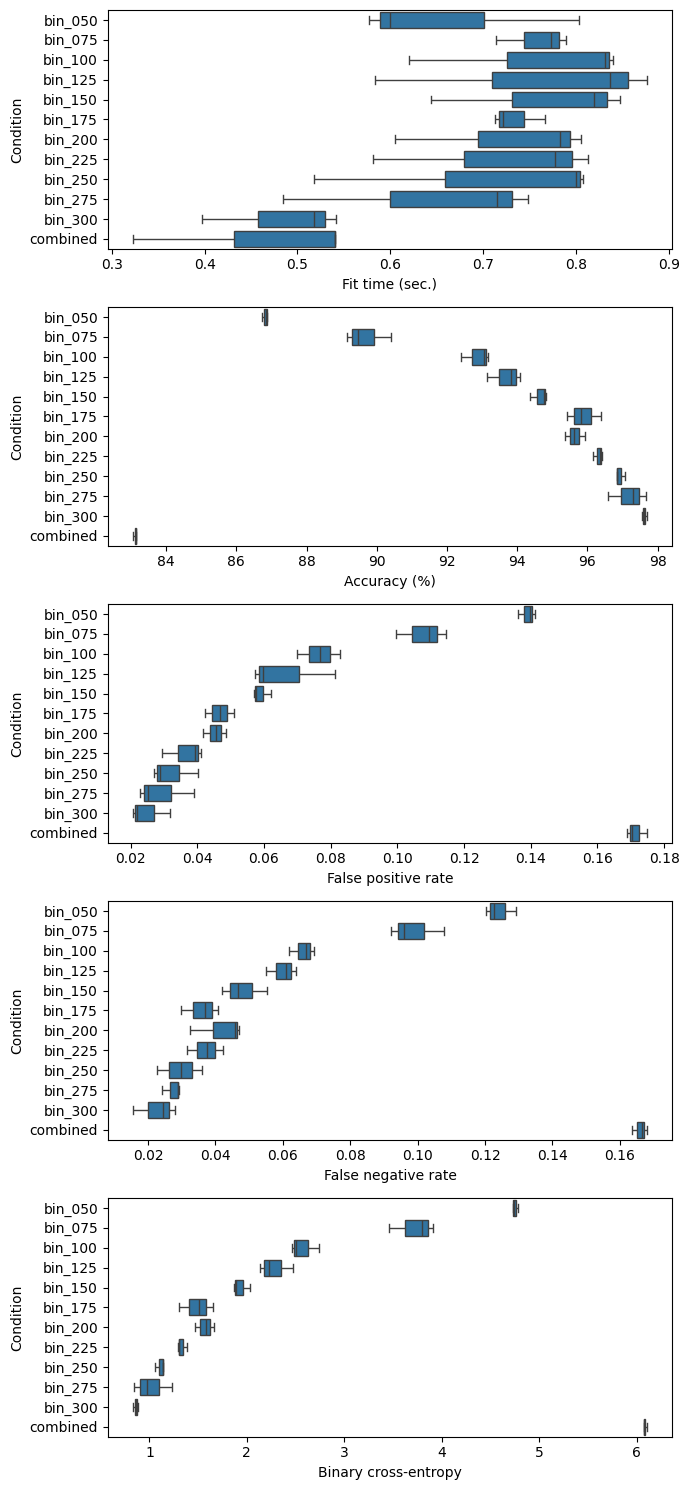

In [5]:
parsed_results = xgb_funcs.cross_validate_bins(input_file, scoring_funcs, parsed_results, 5)
plot_funcs.plot_cross_validation(plots, parsed_results).show()

### 2.2. Cross-validation: shuffled control

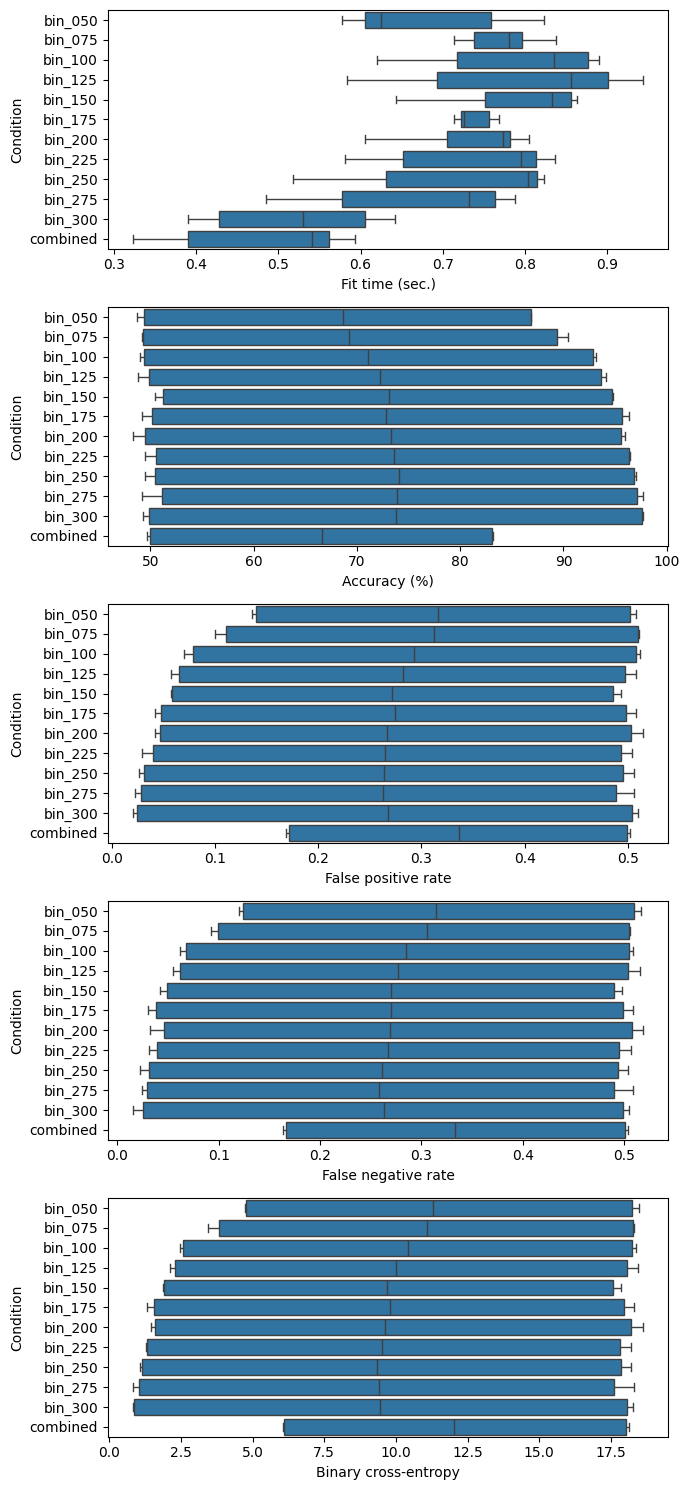

In [6]:
parsed_results = xgb_funcs.cross_validate_bins(input_file, scoring_funcs, parsed_results, 5, shuffle_control = True)
plot_funcs.plot_cross_validation(plots, parsed_results).show()

OK, cool! That works great - the real classifier is definitely performing better than the shuffled control. Lots of things to say here, so I'll make a list:

1. The performance in the longer bins is impressive - we get to and well above 95% accuracy with no tuning or hyperparameter optimization at all.
2. Performance on short text fragments is not great in comparison. We don't get to 90% accuracy until bin 75 which contains fragments between 26 and 75 words. One of the things I know people would want to use this for is spotting bot posts on social media. But i'm starting to think content moderation is a totally different problem all together.
3. We may be leaving some accuracy on the table - remember, the bins overlap so each fragment is seen by two different classifiers. E.g. a 30 word fragment is scored by the classifiers for bins 50 and 75. Next step should probably be to combine the outputs to come up with the final classification.
4. At this point I think we might benefit from more data - some of these bins have only a few hundred or a few thousand fragments in them. Unfortunately, the bins we are performing best on are the ones with the least data, but still...
5. Cross-validation is smoking fast - using multiprocessing to parallelize over the bins and then a joblib context with a threading backend to give scikit-learn control over parallelism in the workers works great. Thought that was going to be a harder problem than it was.

Stick with it, we are almost there. I swear all of this will be worth it in the end. Next, we need to do two things:

1. Tune hyperparameters in each bin, saving the classifier for each after it has been trained using all of the training data with the winning parameters.
2. Figure out how to combine the class probabilities coming from each bin into a single prediction.

To help with thinking about that last point, let's draw a diagram for the first two bins:

```text

Fragment length (words): 1    5    10   15   25   30   35   40   45   50   55   60   65   70   75  80    85   90   95   100  105
                         +----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
                 bin 50: |1                                         50|                        |                        |
                         +--------------------------------------------+                        |                        |
                 bin 75:                      |26                                            75|                        |
                                              +------------------------------------------------+                        |
                bin 100:                                               |51                                           100|
                                                                       +------------------------------------------------+
```

OK, cool, that helped. So ignoring the start and end of the range where we will have some fragments that are only scored by one classifier, the solution is easy, the 'second stage' classifier is a second set of models each take a length range equal to each overlap between the bins. So for example, here's how it would work for a fragment of length 36 looking at the above diagram.

1. Fragment gets scored by first stage bin 50 classifier.
2. Fragment gets scored by first stage bin 75 classifier.
3. Score from each classifier becomes new feature, maybe 'short score' and 'long score' or something similar.
4. Dual scored fragment is sent to a second stage '26-50' classifier that takes all of the features, including the short and long scores from the first stage classifiers, to predict a final class probability. Bang. Done.

Only other edge cases are fragments that are below 26 words or above 275 words. These are only scored by the first stage classifier for their bin and that class probability is used to make the call. For production, we can send a warning about short fragments with the prediction and for 'too long' fragments we can split and/or sample, something like that. Easy.

## 3. Hyperparameter tuning

In [7]:
from __future__ import annotations

import h5py
import pandas as pd
import multiprocessing as mp

from xgboost import XGBClassifier
from scipy.stats import uniform, randint
from sklearn.model_selection import RandomizedSearchCV
from joblib import parallel_backend

In [18]:
def hyperparameter_tune_bin(
        features_df: pd.DataFrame, 
        labels: pd.Series,
        parameter_distributions: dict,
        scoring_funcs: dict,
        n_iterations: int, 
        threads_per_worker: int,
        bin_id: str,
        shuffle_control: bool
) -> tuple[str, dict]:
    
    '''Runs hyperparameter tuning on bin data with XGBClassifier'''

    # Clean up the features for training
    features = xgb_funcs.prep_data(features_df, shuffle_control)

    # Use threading backend for parallelism because we are running in a
    # daemonic worker process started by multiprocessing and thus can't 
    # use multiprocessing again to spawn more processes
    with parallel_backend('threading', n_jobs = threads_per_worker):

        # Instantiate the classifier
        model = XGBClassifier()

        # Set-up the hyperparameter search
        classifier = RandomizedSearchCV(
            model,
            parameter_distributions,
            scoring = scoring_funcs,
            refit = 'negated_binary_cross_entropy',
            n_jobs = threads_per_worker,
            return_train_score = True,
            n_iter = n_iterations
        )

        # Run the hyperparameter search
        results = classifier.fit(features, labels)

    return bin_id, results

In [19]:
def hyperparameter_tune_bins(
        input_file: str,
        parameter_distributions: dict,
        scoring_funcs: dict,
        n_iterations: int = 3, 
        workers: int = 3, 
        threads_per_worker: int = 3,
        shuffle_control: bool = False
) -> dict:

    '''Main function to parallelize hyperparameter optimization of XGBoost classifier
    over the data's length bins.'''

    # Get the bins from the hdf5 file's metadata
    data_lake = h5py.File(input_file, 'r')
    bins = dict(data_lake.attrs.items())
    data_lake.close()

    # Instantiate worker pool. For now, use constant 4 workers at a
    # time. We have 12 bins, so this means each worker will have to optimize
    # three bins. But, since we have 20 CPUs we can use up to 6 CPUs per
    # worker to parallelize the hyperparameter optimization
    pool = mp.Pool(
        processes = workers,
        maxtasksperchild = 1
    )

    # Holder for returns from workers
    async_results = []

    # Open a connection to the hdf5 dataset via PyTables with Pandas
    data_lake = pd.HDFStore(input_file)

    # Loop on the bins
    for bin_id in bins.keys():

        # Pull the training features for this bin
        bin_training_features_df = data_lake[f'training/{bin_id}/features']

        # Pull the training labels for this bin
        bin_training_labels = data_lake[f'training/{bin_id}/labels']

        async_results.append(
            pool.apply_async(hyperparameter_tune_bin,
                args = (
                    bin_training_features_df, 
                    bin_training_labels,
                    parameter_distributions,
                    scoring_funcs,
                    n_iterations, 
                    threads_per_worker,
                    bin_id,
                    shuffle_control
                )
            )
        )

    # Clean up
    pool.close()
    pool.join()

    # Get the results
    results = [async_result.get() for async_result in async_results]

    print()

    # Parse the results
    parsed_results = {}

    for result in results:

        bin_id = result[0]
        best_parameters = result[1]
        parsed_results[bin_id] = best_parameters

    data_lake.close()

    return parsed_results

In [20]:
# Define hyperparameter distributions for randomized grid search
parameter_distributions = {
    'learning_rate': uniform(loc = 0.001, scale = 0.999),
    'gamma': uniform(loc = 0.0, scale = 1.0),
    'max_depth': randint(1, 200),
    'min_child_weight': uniform(loc = 0.0001, scale = 0.9999),
    'subsample': uniform(loc = 0.5, scale = 0.5),
    'reg_alpha': uniform(loc = 0.0, scale = 1.0),
    'reg_lambda': uniform(loc = 0.0, scale = 1.0),
    'n_estimators': randint(1, 200),
    'num_parallel_tree': randint(1, 10)
}

# Redefine the scoring functions, this time using negated binary
# cross-entropy so that when RandomizedSearchCV try to maximize it, it's
# doing the right thing.
scoring_funcs = {
    'negated_binary_cross_entropy': make_scorer(helper_funcs.negated_binary_cross_entropy),
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

n_iterations = 12
workers = 3
threads_per_worker = 6

# Do the optimization
results = hyperparameter_tune_bins(input_file, parameter_distributions, scoring_funcs, n_iterations, workers, threads_per_worker)

In [29]:
def parse_hyperparameter_tuning_results(results: dict) -> tuple[dict, pd.DataFrame]:
    '''Takes results dictionary from hyperparameter_tune_bins(). Returns
    cross-validation results as Pandas dataframe and the winning parameters and
    models in a dictionary where the bin id is the key.'''

    # Holders for parsed results
    cv_results = []
    winners = {}

    # Loop on the bins and plot the results for each
    for bin_id, result in results.items():
        print(f'{bin_id} best score: {result.best_score_}')

        # Collect the best estimator and it's parameters for each bin
        winners[bin_id] = {}
        winners[bin_id]['model'] = result.best_estimator_
        winners[bin_id]['parameters'] = result.best_params_

        # Get the cross-validation results for this bin as a dataframe
        cv_result = pd.DataFrame(result.cv_results_)

        # Add a column for the bin ID
        cv_result ['bin'] = [bin_id] * len(cv_result)

        # Add the dataframe for this bin to the results
        cv_results.append(cv_result)

    # Combine the cross-validation dataframe
    cv_results = pd.concat(cv_results)

    return winners, cv_results

winners, cv_results = parse_hyperparameter_tuning_results(results)

bin_050 best score: -4.4509421815954955
bin_075 best score: -3.437486129257335
bin_100 best score: -2.417068824352913
bin_125 best score: -2.0595240478753047
bin_150 best score: -1.8693800984900228
bin_175 best score: -1.5116130154745522
bin_200 best score: -1.4046863261098725
bin_225 best score: -1.1842223258681241
bin_250 best score: -1.0510690534814413
bin_275 best score: -0.8577597338403532
bin_300 best score: -0.8281019521244041
combined best score: -6.019273076836482


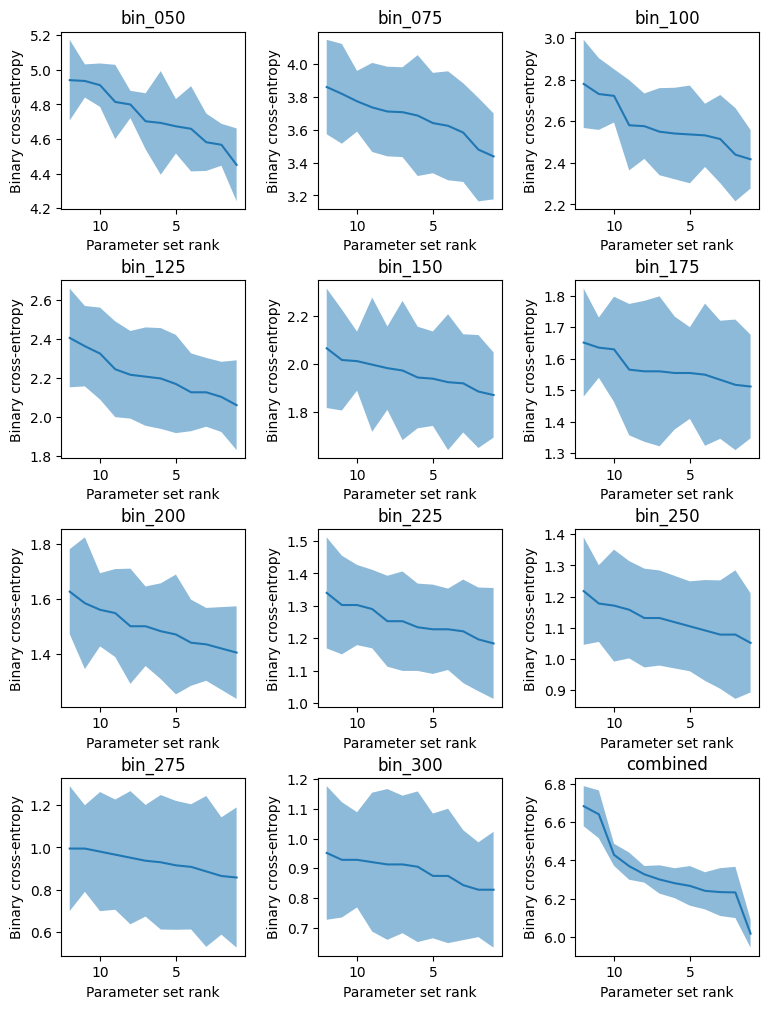

In [30]:
import matplotlib.pyplot as plt

def plot_hyperparameter_tuning(cv_results: pd.DataFrame) -> plt:
    '''Takes parsed results from parse_hyperparameter_tuning_results()
    plots the binary cross entropy of each step by the step's rank
    for each bin, returns the plot object'''

    # Set up a figure for 12 bins
    fig, axs = plt.subplots(
        4,
        3,
        figsize = (9, 12),
        gridspec_kw = {'wspace':0.4, 'hspace':0.4}
    )

    # Plot the results for each bin on a separate axis
    for bin_id, ax in zip(cv_results['bin'].unique(), axs.reshape(-1)):

        bin_results = cv_results[cv_results['bin'] == bin_id]
        sorted_bin_results = bin_results.sort_values('rank_test_negated_binary_cross_entropy')

        ax.set_title(f'{bin_id}')
        ax.set_xlabel('Parameter set rank')
        ax.set_ylabel('Binary cross-entropy')
        ax.invert_xaxis()


        ax.fill_between(
            sorted_bin_results['rank_test_negated_binary_cross_entropy'],
            sorted_bin_results['mean_test_binary_cross_entropy'] + sorted_bin_results['std_test_binary_cross_entropy'],
            sorted_bin_results['mean_test_binary_cross_entropy'] - sorted_bin_results['std_test_binary_cross_entropy'],
            alpha = 0.5
        )

        ax.plot(
            sorted_bin_results['rank_test_negated_binary_cross_entropy'],
            sorted_bin_results['mean_test_binary_cross_entropy']
        )

    return plt

plot_hyperparameter_tuning(cv_results).show()